<a href="https://colab.research.google.com/github/zhouchun0105/Bitcoin-Price-and-Movement-Prediction/blob/main/Bitcoin_Price_and_its_Movement_Direction_Prediction_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**Bitcoin Price and its Movement Direction Prediction**
*Using Linear Regression, Logistics Regression, ARIMA, Simple RNN and LSTM Models.*

# **Packages**

In [11]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib.image as mpimg

import seaborn as sns
sns.set(rc={'figure.figsize':(10,6)})
custom_colors = ["#4e89ae", "#c56183","#ed6663","#ffa372"]

import datetime as datetime
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout

#**Data Cleaning**

Import Dataset

In [12]:
df = pd.read_csv("/content/bitcoin.csv")

Modify Timestamp

In [13]:
# Change the Timestamp column attribute to datetime
df['Timestamp'] = pd.to_datetime(df['Timestamp'],unit='s')
# Enable to refer to the row by index 
df = df.set_index('Timestamp')

Spot the missing values

In [14]:
missed = pd.DataFrame()
missed['column'] = df.columns

missed['percent'] = [round(100* df[col].isnull().sum() / len(df), 2) for col in df.columns]
missed = missed.sort_values('percent',ascending=False)
missed = missed[missed['percent']>0]


Fill in the missing data

In [15]:
def fill_missing(df):
    ### function to impute missing values using interpolation ###
    df['Open'] = df['Open'].interpolate()
    df['Close'] = df['Close'].interpolate()
    df['Weighted_Price'] = df['Weighted_Price'].interpolate()
    df['Volume_(BTC)'] = df['Volume_(BTC)'].interpolate()
    df['Volume_(Currency)'] = df['Volume_(Currency)'].interpolate()
    df['High'] = df['High'].interpolate()
    df['Low'] = df['Low'].interpolate()
    
fill_missing(df)

Remove NA rows

In [16]:
df = df.dropna()

# **Feature Engineering**

Add `Price` column by averaging Low and Close

In [17]:
df["Price"] = df[["Open","High","Low","Close"]].mean(axis=1)

Add `Return` Column by calculating the difference from now to previous second's `Price`

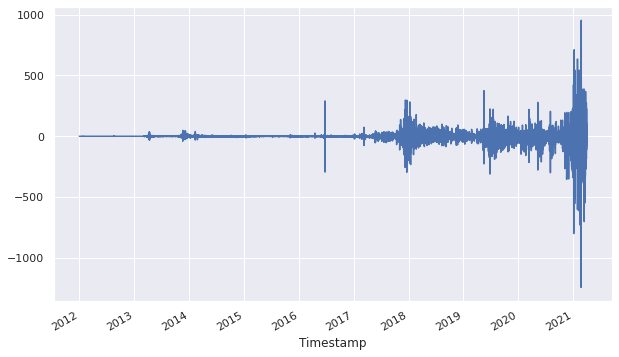

In [18]:
df["Return"] = df["Price"].diff()
df["Return"].plot(x="Timestamp", y="Return")

Add `Direction` column showing if bitcoin price is going up or down.

In [19]:
df["Direction"] = pd.Series(df["Return"] > 0)
df["Direction"] = "Down"
df.loc[(df["Return"] > 0), "Direction"] = "Up"

Add `Percentage_Return` column to show the perentage return per seconds

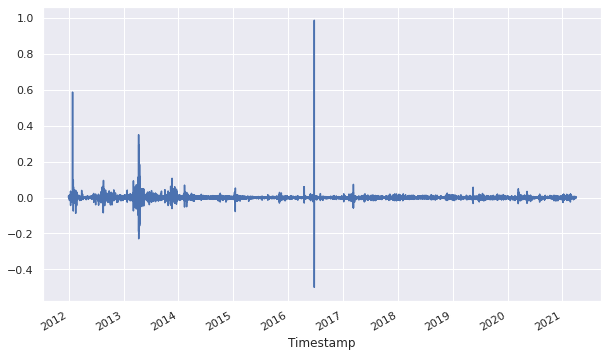

In [20]:
df["Percentage_Return"] = ((df["Return"].shift(periods=-1))/ (df["Price"])).shift(periods=1)
df["Percentage_Return"].plot()

Add Lag1, Lag2, Lag3, Lag4, Lag5 columns as t-1, t-2, t-3, t-4, and t-5 features to predict bitcoin price at t (in seconds)

In [21]:
df["Lag1"]= df["Percentage_Return"].shift(periods=-1)
df["Lag2"]= df["Percentage_Return"].shift(periods=-2)
df["Lag3"]= df["Percentage_Return"].shift(periods=-3)
df["Lag4"]= df["Percentage_Return"].shift(periods=-4)
df["Lag5"]= df["Percentage_Return"].shift(periods=-5)
df.dropna()

,Open,High,Low,Close,Volume_(BTC),Volume_(Currency),Weighted_Price,Price,Return,Direction,Percentage_Return,Lag1,Lag2,Lag3,Lag4,Lag5
Timestamp,,,,,,,,,,,,,,,,
2011-12-31 07:53:00,4.390,4.390,4.39,4.39,0.555046,2.436653,4.390000,4.3900,0.0000,Down,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2011-12-31 07:54:00,4.390,4.390,4.39,4.39,0.654511,2.873305,4.390000,4.3900,0.0000,Down,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2011-12-31 07:55:00,4.390,4.390,4.39,4.39,0.753977,3.309958,4.390000,4.3900,0.0000,Down,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2011-12-31 07:56:00,4.390,4.390,4.39,4.39,0.853442,3.746611,4.390000,4.3900,0.0000,Down,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2011-12-31 07:57:00,4.390,4.390,4.39,4.39,0.952907,4.183264,4.390000,4.3900,0.0000,Down,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-03-30 23:51:00,58677.050,58699.900,58660.00,58699.90,2.672676,156832.692130,58680.021260,58684.2125,2.8925,Up,0.000049,0.000234,0.000234,0.000545,-0.000263,-0.000478
2021-03-30 23:52:00,58697.865,58715.565,58679.17,58699.20,1.440329,84520.873706,58691.157958,58697.9500,13.7375,Up,0.000234,0.000234,0.000545,-0.000263,-0.000478,-0.000228
2021-03-30 23:53:00,58718.680,58731.230,58698.34,58698.50,0.207983,12209.055282,58702.294657,58711.6875,13.7375,Up,0.000234,0.000545,-0.000263,-0.000478,-0.000228,0.000372


Cleaned Dataset Display

In [22]:
df.shape

(4857377, 16)

In [23]:
df.head()

,Open,High,Low,Close,Volume_(BTC),Volume_(Currency),Weighted_Price,Price,Return,Direction,Percentage_Return,Lag1,Lag2,Lag3,Lag4,Lag5
Timestamp,,,,,,,,,,,,,,,,
2011-12-31 07:52:00,4.39,4.39,4.39,4.39,0.455581,2.000000,4.39,4.39,NaN,Down,NaN,0.0,0.0,0.0,0.0,0.0
2011-12-31 07:53:00,4.39,4.39,4.39,4.39,0.555046,2.436653,4.39,4.39,0.0,Down,0.0,0.0,0.0,0.0,0.0,0.0
2011-12-31 07:54:00,4.39,4.39,4.39,4.39,0.654511,2.873305,4.39,4.39,0.0,Down,0.0,0.0,0.0,0.0,0.0,0.0
2011-12-31 07:55:00,4.39,4.39,4.39,4.39,0.753977,3.309958,4.39,4.39,0.0,Down,0.0,0.0,0.0,0.0,0.0,0.0
2011-12-31 07:56:00,4.39,4.39,4.39,4.39,0.853442,3.746611,4.39,4.39,0.0,Down,0.0,0.0,0.0,0.0,0.0,0.0


#**Exploratory Data Analysis**

Zheming's Part

Produce a kernal density plot for Price (refer to Lecture 7 02-Exploratory-Data-Analysis.ipynb)

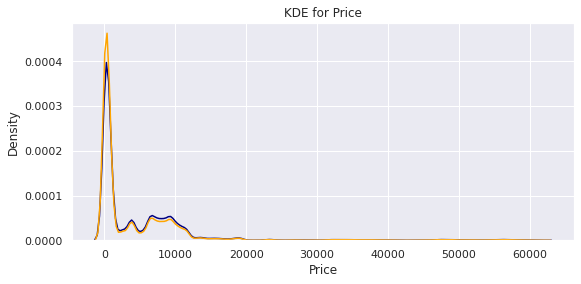

In [24]:
def kdeplot(feature):
    plt.figure(figsize=(9, 4))
    plt.title("KDE for {}".format(feature))
    ax0 = sns.kdeplot(df[df['Direction'] == 'Up'][feature].dropna(), color= 'navy', label= 'Churn: No')
    ax1 = sns.kdeplot(df[df['Direction'] == 'Down'][feature].dropna(), color= 'orange', label= 'Churn: Yes')
kdeplot('Price')


Analyze correlations with seaborn heatmap

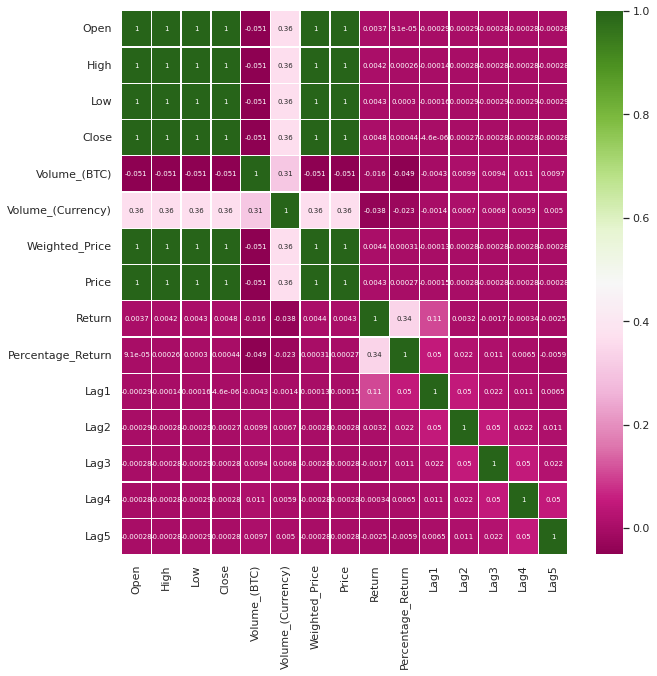

In [25]:
corr = df.corr()
plt.figure(figsize=[10,10])
plt.rcParams['font.size']=7
sns.heatmap(corr, cmap='PiYG', annot= True, linewidths=0.3 );

In [26]:
def triple_plot(x, title,c):
    fig, ax = plt.subplots(3,1,figsize=(25,10),sharex=True)
    sns.distplot(x, ax=ax[0],color=c)
    ax[0].set(xlabel=None)
    ax[0].set_title('Histogram + KDE')
    sns.boxplot(x, ax=ax[1],color=c)
    ax[1].set(xlabel=None)
    ax[1].set_title('Boxplot')
    sns.violinplot(x, ax=ax[2],color=c)
    ax[2].set(xlabel=None)
    ax[2].set_title('Violin plot')
    fig.suptitle(title, fontsize=30)
    plt.tight_layout(pad=3.0)
    plt.show()

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


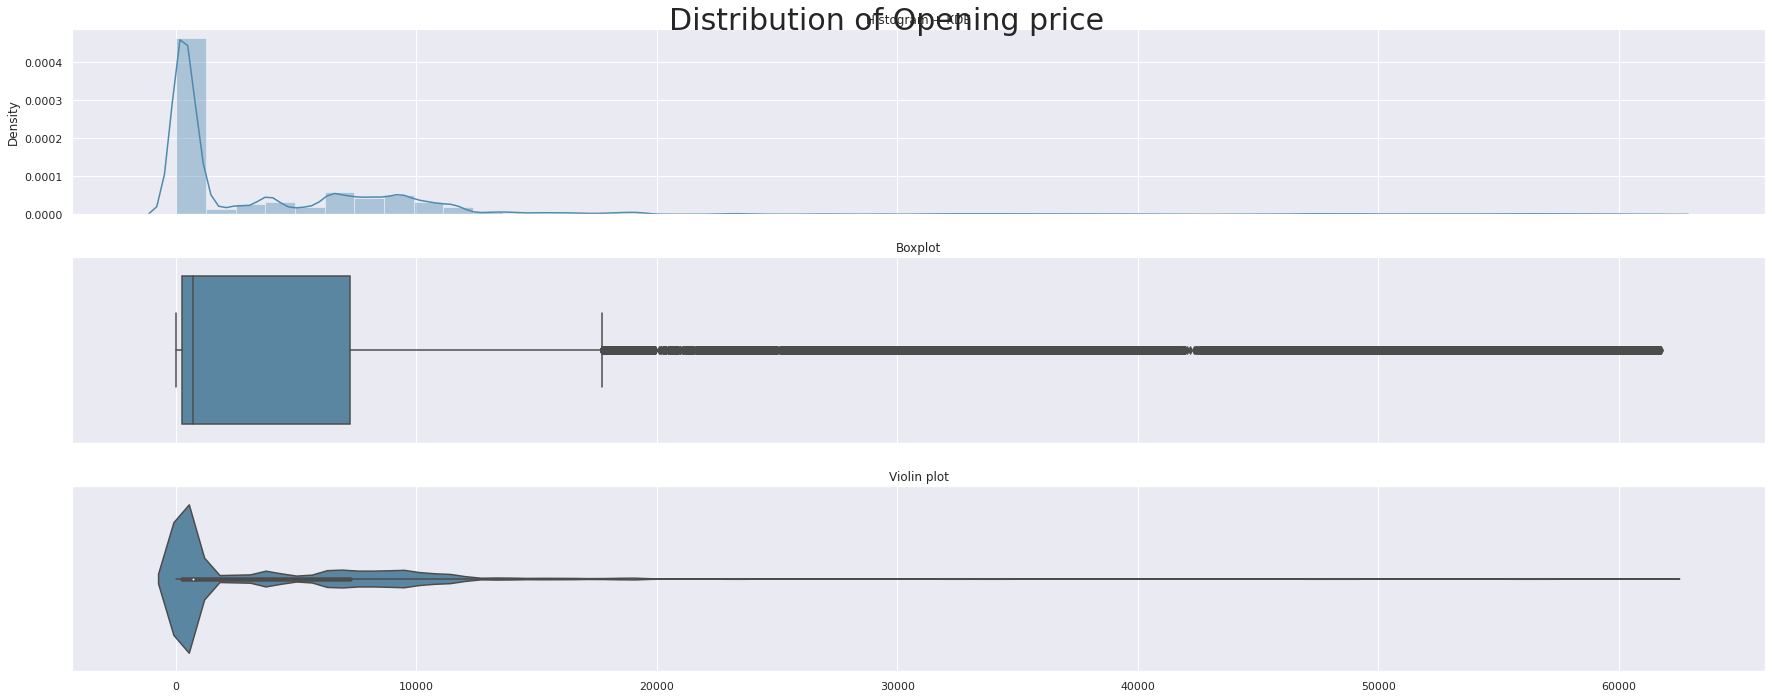

In [27]:
triple_plot(df['Open'],'Distribution of Opening price',custom_colors[0])

# **Linear Regression**

Ji Qi's part here

#**Logistics Regression**

Ji Qi's part here

# **ARIMA Model**

Geech's part here

Arima model stands for Auto Regressive Intergrated Moving Average. It is a forcasting algorimth that uses the past values to predict future values such as intercept (c), Lags (AR), forecast errors (MA). 

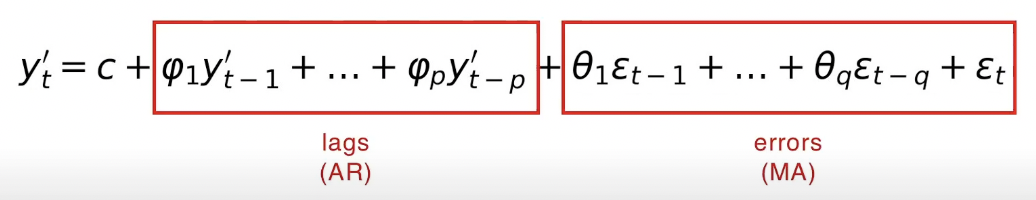

In [28]:
df = df.resample("24H").mean()

In [29]:
df.head(5)

,Open,High,Low,Close,Volume_(BTC),Volume_(Currency),Weighted_Price,Price,Return,Percentage_Return,Lag1,Lag2,Lag3,Lag4,Lag5
Timestamp,,,,,,,,,,,,,,,
2011-12-31,4.476415,4.478946,4.476415,4.478946,17.940426,79.495594,4.477370,4.477681,0.000196,4.387418e-05,4.382886e-05,0.000044,0.000044,0.000044,0.000044
2012-01-01,4.765576,4.765576,4.765576,4.765576,6.790640,32.971105,4.765576,4.765576,0.000292,6.093222e-05,6.093222e-05,0.000061,0.000061,0.000061,0.000061
2012-01-02,5.006549,5.006549,5.006549,5.006549,15.183373,75.932706,5.006549,5.006549,0.000055,1.101191e-05,1.105840e-05,0.000011,0.000011,0.000011,0.000011
2012-01-03,5.206530,5.206530,5.206530,5.206530,7.917041,40.795994,5.206530,5.206530,-0.000005,-8.537691e-07,-9.760750e-07,-0.000001,-0.000001,-0.000001,-0.000001
2012-01-04,5.202511,5.241699,5.202511,5.241699,13.659736,72.860096,5.216680,5.222105,0.000412,7.683091e-05,7.697206e-05,0.000077,0.000077,0.000077,0.000078


In [30]:
df.shape

(3379, 15)

We are going to only use the Closing price of BItcoin to predict the future value. (Univariate time series forcasting) 

In [31]:
df= df[["Close"]].copy()

In [32]:
df.describe()

,Close
count,3376.000000
mean,4605.639551
std,8207.350418
min,4.360638
25%,245.230391
50%,697.703091
75%,7242.406733
max,60460.509722


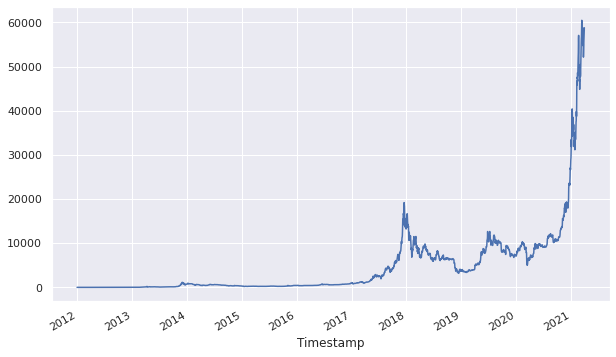

In [33]:
#drop any missing values for closing columns 
df.Close.dropna().plot()

In [34]:
from numpy import log

We split the group into two inorder to calculate the mean and variance of the two groups. If the mean and variance looks very different, our data is non-stationary time series so we cannot reject the null. A non- stationary time series is one that depends on time at which the series is observed.  

In [35]:
# use log to make the distribution more flat.
X = df.Close
X=log(X)
split = round(len(X) / 2)
X1, X2 = X[0:split], X[split:]
mean1, mean2 = X1.mean(), X2.mean()
var1, var2 = X1.var(), X2.var()
print('mean1=%f, mean2=%f' % (mean1, mean2))
print('variance1=%f, variance2=%f' % (var1, var2))

mean1=4.833398, mean2=8.641288
variance1=2.801974, variance2=1.048945


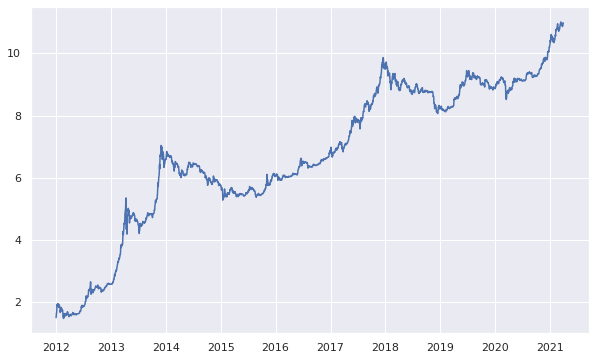

In [36]:
#plot a graph after using log to flatten the closing price 
plt.plot(X)
plt.show()

Another way to see if our data is stationary by using adfuller() function. The function perform ADF test.

Null hypothesis of ADF is that the time series is not stationary. So if P-value is bigger than 0.05. we cannot reject Null.

 **Augmented Dickey Fuller test**

In [39]:
from statsmodels.tsa.stattools import adfuller

In [42]:
# d=0 if the time series is stationary 
test_adf = adfuller(df.Close.dropna())

print(f" ADF Statistics: {test_adf[0]}")
print(f" P-value: {test_adf[1]}")

 ADF Statistics: 6.1895129620459315
 P-value: 1.0


The P-value that we got showed that the time series is 100% non- staitonary. So We are going to tranform the non- stationary data by taking the differences of consecutive observations. 

In [53]:
#use Pandas's diff()
df["diff_1"] = df["Close"].diff(periods=1)
df["diff_2"] = df["Close"].diff(periods=2)
df["diff_3"] = df["Close"].diff(periods=3)

df.head(6)

,Close,diff_1,diff_2,diff_3
Timestamp,,,,
2011-12-31,4.478946,NaN,NaN,NaN
2012-01-01,4.765576,0.286630,NaN,NaN
2012-01-02,5.006549,0.240972,0.527602,NaN
2012-01-03,5.206530,0.199982,0.440954,0.727584
2012-01-04,5.241699,0.035169,0.235151,0.476123
2012-01-05,6.162639,0.920940,0.956109,1.156090


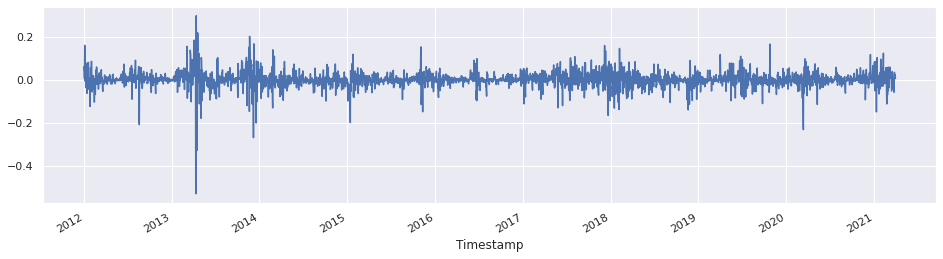

In [55]:
#use log to remove non-linearity 
transformed_df = pd.Series(log(df["Close"])).diff().dropna()

transformed_df.plot(figsize=(16, 4))

The time series is now more stationary. 

In [59]:
#run the adf test with modified data 
results = adfuller(transformed_df)

print(f" ADF Statistics: {results[0]}")
print(f" P-value: {results[1]}")

 ADF Statistics: -10.552563318040379
 P-value: 8.105065720567304e-19


**Hyperparameter Tuning**

Hyperparameter of Arima Model are P,d and q. P refers to the order of the autoregressive term. d refers to the numbers of differences inorder to make the time series stationary. q is the order of the moving average term. 

In [60]:
#Autocorrelation Function (ACF)
from statsmodels.graphics.tsaplots import plot_acf

**Finding d***

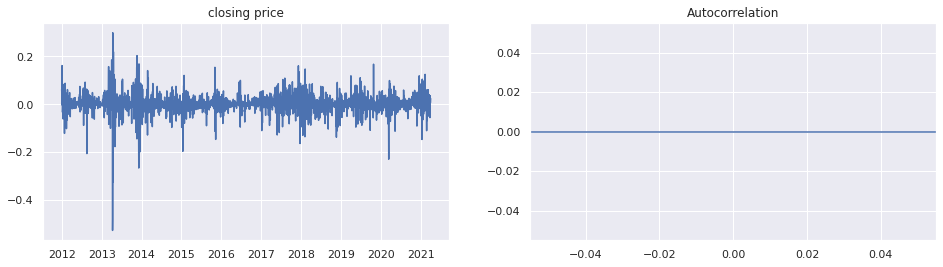

In [61]:
#finding d- order of differencing 
fig, (ax1, ax2)= plt.subplots(1, 2, figsize= (16, 4))

ax1.plot(transformed_df)
ax1.set_title('closing price')
plot_acf(df.Close, ax= ax2);

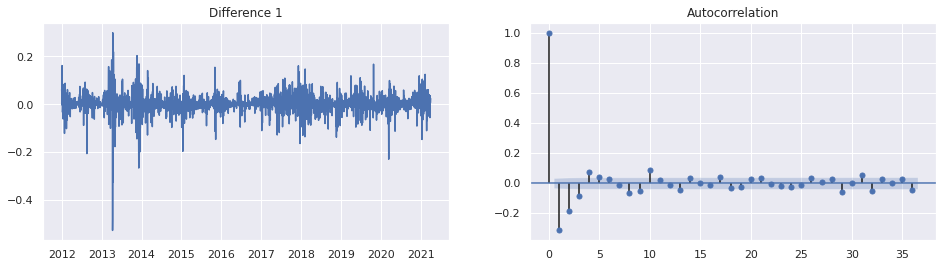

In [76]:
diff1 = transformed_df.diff().dropna()

fig, (ax1, ax2)= plt.subplots(1, 2, figsize= (16, 4))

ax1.plot(transformed_df)
ax1.set_title('Difference 1')
plot_acf(diff1, ax= ax2);

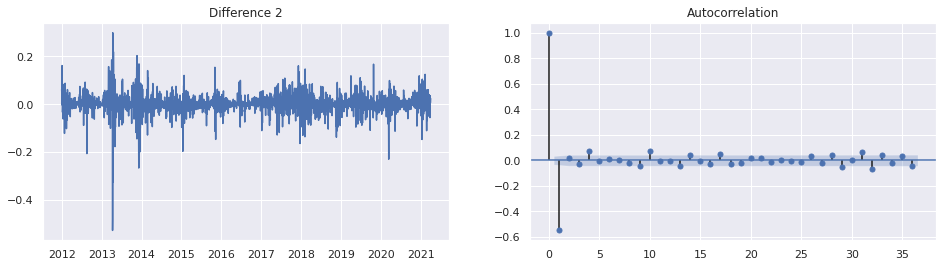

In [77]:
diff2 = transformed_df.diff().diff().dropna()

fig, (ax1, ax2)= plt.subplots(1, 2, figsize= (16, 4))

ax1.plot(transformed_df)
ax1.set_title('Difference 2')
plot_acf(diff2, ax= ax2);

The time series reaches stationary after one differencing because the autocorrolation plot for the 2nd differencing, the lag went into the negative zone. This indicates that the series might have been overdifferenced. 

Therefore, we can have d=1

In [83]:
!pip install pmdarima

To make sure that the interpretation is correct, we're going to use ndiff() package to find d value 

In [84]:
from pmdarima.arima.utils import ndiffs

ImportError: ignored

In [ ]:
ndiffs(df.Close.dropna(), test="adf") #deciding d for order of differencing 

In [ ]:
from statsmodels.graphics.tsaplots import plot_pacf

In [ ]:
# Finding P- the order of Auto regressive term in the ARIMA model. It refers to the numbers of lags to be used as predictors. 
# Inspecting the partial autocorrelation plot (PACF)
diff = df.Close.diff().dropna()

fig, (ax1, ax2)= plt.subplots(1, 2, figsize= (16, 4))

ax1.plot(df.Close)
ax1.set_title('Difference 1')
ax2.set_ylim(0, 1)
plot_pacf(diff, ax= ax2);

Finding q is the order of the moving average (MA)term. 
the number of lagged forecast errors that should go into the ARIMA model
use ACF plot to find q 

In [ ]:
diff = df.Close.diff().dropna()

fig, (ax1, ax2)= plt.subplots(1, 2, figsize= (16, 4))

ax1.plot(df.Close)
ax1.set_title('Difference')
ax2.set_ylim(0, 1)
plot_acf(diff, ax= ax2);

In [ ]:
from statsmodels.tsa.arima_model import ARIMA

In [ ]:
#fitting the arima model 
# ARIMA model 
ari_model = ARIMA(df.Close.dropna(), order=(1,1,1))
result= ari_model.fit(disp= False) # disp is False 

In [ ]:
print(result.summary())

In [ ]:
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import OLSInfluence

In [ ]:
#plot residuals 
# res = pd.DataFrame(test_adf.resid)
res = sms.omni_normtest(test_adf.resid)
fig, (ax1, ax2)= plt.subplots(1, 2, figsize= (16, 4))

ax1.plot(res)
ax2.hist(res, density= True);

In [ ]:
#Actual vs. Fitted 
test_adf.plot_predict(start= 1, end= 60, dynamic= False);

In [ ]:
# Split train set 
n= int(len(df)*0.8)
train_set = df.Close.dropna()[:n]
test_set = df.Close.dropna()[n:]

In [ ]:
print(len(train_set))
print(len(test_set))

In [ ]:
model= ARIMA(train_set, order= (1,1,1))
result_train = model.fit(disp= False)

In [ ]:
result_train.summary()

In [ ]:
#forecast 30 steps 
steps =30 
fc, se, conf = result.forecast(steps)

In [ ]:
# out of sample forecast
fc

In [ ]:
# standard error of the forecast 
se

In [ ]:
#upper bound and lower bound confidence level 
conf

In [ ]:
fc = pd.Series(fc, index= train_set[:step].index)
lower = pd.Series(conf[:, 0]), index= train_set[:step].index)
upper = pd.Series(conf[:, 1]), index= train_set[:step].index)

In [ ]:
plt.figure(figsize=(16, 8))
plt.plot(train_set[:steps], label= "actual")
plt.plot(fc, label= "forecast")
plt.fill_between(lower.index, lower, upper, color= "k", alpha= 0.1)
plt.title("Forecast Vs Actual")
plt.legend(loc= "Upper Left")

# **Simple RNN**

Yihan Jia's part here

# **LSTM Model**

Chun Zhou and Vaibhav's part here

LSTM stands for long short-term memory networks. It is a variety of recurrent neural network (RNN) in the deep learning field. LSTM is effective when predicting sequence of data.

#**References**

1. "Bitcoin Price Prediction with LSTM". Ansel D'souza. https://www.kaggle.com/anseldsouza/bitcoin-price-prediction-with-lstm

2. How to Create an ARIMA Model for Time Series Forecasting in Python. https://machinelearningmastery.com/arima-for-time-series-forecasting-with-python/

3. How to Grid Search ARIMA Model Hyperparameters with Python. https://machinelearningmastery.com/grid-search-arima-hyperparameters-with-python/